# ETS lab Tutorial 4: Orbital objects - II
Template by André Moitinho

***
## Setup


Load the required libraries. See previous tutorial for a thourough description.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import ephem
import datetime
import csv

Set observer's coordinates and time for ephem. <br>
This example uses Lisbon.

In [2]:
obs = ephem.Observer()
obs.lat = np.deg2rad(38.717)
obs.long = np.deg2rad(9.133)
obs.date = datetime.datetime.today()

## Processing TLEs on the large scale

Here is where you process the whole TLE file, propagate orbits, compute 3D cartesian positions of the satellites and write the output to a file for opening in other analsys software. You will inspect this output file with "topcat" (http://www.star.bris.ac.uk/~mbt/topcat)


I provide a utility function for reading the TLE file into a list of "EarthSatellite" objects. It is for you to understand how the function works or use another method.

Ler os tle's todos e para um tempo determinado ver onde é que estão os objetos. Calcular a posição de todos os objetos num determinado instante de tempo.

No notebook anterior definimos as linhas os objetos orbitais, fixas para cada objeto. A função a seguir carrega um ficheiro tle e cria uma lista de satélites. Abrir o ficheiro, cria lista vazia, ler primeira linha (l1 do primeiro elemento), enquanto o ficheiro for iterado, ler o l2, ler o l3, adiciona um elemnto à lista de satélites com l1, l2 e l3. Acaba o ciclo a ler a linha seguinte para não dar erro no while. Quando chega ao fim do ficheiro dá um erro porque acabou o loop, então fecha o ficheiro. Diz quantos satélites foram adicionados (len(satlist)), devolve a lista.

In [3]:
# Auxiliary function for reading 3LE files

def loadTLE(filename):
    """ Loads a TLE file and creates a list of satellites."""
    f = open(filename)
    satlist = []
    l1 = f.readline()
    while l1:
        l2 = f.readline()
        l3 = f.readline()
        sat = ephem.readtle(l1,l2,l3)
        satlist.append(sat)
        # print(sat.name) # uncomment to print satellite names on the screen, but it will take a looong time.
        l1 = f.readline()

    f.close()
    print("%i satellites loaded into list"%len(satlist))
    return satlist

**Read TLE file into a list of "EarthSatellite" objects**

In [5]:
# Read 3le file into a list of "EarthSatellite" objects. Use the loadTLE function:

objlist = loadTLE('SpaceTrack_3le_07112023.txt')

25875 satellites loaded into list


### Compute orbits and create arrays of X,Y,Z cartesian positions relative to the Earth of objects in the TLE file.

Sometimes, ephem will not compute the positions and exit with an error. This is often due to the old date of some TLEs. To overcome this unwanted termination, you will have to capture those exceptions and eliminate the problematic satellites from the list. **Print on the screen the names of the satellites that have been discarded.**

Criar as órbitas. Para saber as posições x, y, z, temos que integrar as orbitas naquele momento, em relação à terra. Iterar ao longo da lista dos objetos (que lemos anteriormente) calcular a orbita do objeto em relação ao observador (definido anteriormente). O raio (distância a que está o objeto) é o raio da terra + a elevação. Passar de coordenadas esféricas para cartesianas. (Append com array numpy ficam lentos porque o numpy faz copias do array em cada iteração; é mais rápido fazer append em listas e depois converter para numpy array). 

Fazer a computação com o ficheiro 3le do ano passado 09112022 dá erro (ValueError). Capturar excepções. Usar o método try, se tiver uma exceção, excluir.

In [6]:
# Compute orbits for objects in the TLE file
# Determine their X,Y,Z cartesian positions relative to the Earth.

XX, YY, ZZ = [], [], []


for i in range(0, len(objlist)):
    objlist[i].compute(obs)
    # sometimes positions cannot be computed (date of obs too different from current date, etc). 
    # We will see how to capture these exceptions and delete the object from our lists
#try:
    radius = ephem.earth_radius + objlist[i].elevation
    X = radius * np.cos(objlist[i].sublong) * np.cos(objlist[i].sublat)
    Y = radius * np.sin(objlist[i].sublong) * np.cos(objlist[i].sublat)
    Z = radius * np.sin(objlist[i].sublat)
#except RuntimeError:
    #print("%i deleted %s: cannot compute the body's position at %s" % (i,objlist[i].name,obs.date))
    #X=Y=Z = float('nan')
        
    XX.append(X)
    YY.append(Y)
    ZZ.append(Z)


XX = np.array(XX)
YY = np.array(YY)
ZZ = np.array(ZZ)

#Note that a python list was used for the append phase and then converted to a numpy array. 
#Appending to large numpy arrays can become very slow.

### Plot cartesian XYZ positions in 3D

Note: You might get some warnings which can be safely muted with:
np.warnings.filterwarnings('ignore') or reset with np.warnings.filterwarnings('default')



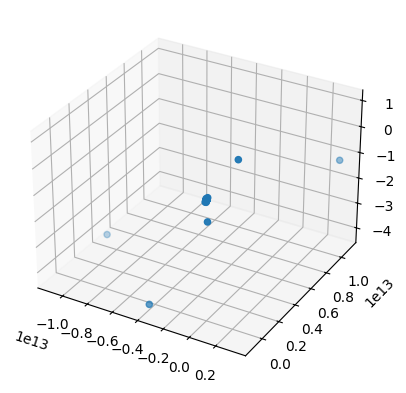

In [7]:
# Plot XYZ in 3D to show our orbital environment:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(XX,YY,ZZ)

Doesn't look good, does it?

There are some outliers at really great distances (see the plot scale). <br>
Lets get rid of them to provide a good view of the LEO and GEO environments.

Below we illustrate:
* the use of **masks** for data selection
* changing the 3D view

Para evitar problemas com a escala devidos a objetos demasiado afastados da terra, vamos colocar uma limitação na distancia dos objetos a considerar (maxrad). Criamos uma máscara a partir duma expressão lógica, que quando aplicada ao array vai selecionar os pontos em que a máscara é true. 

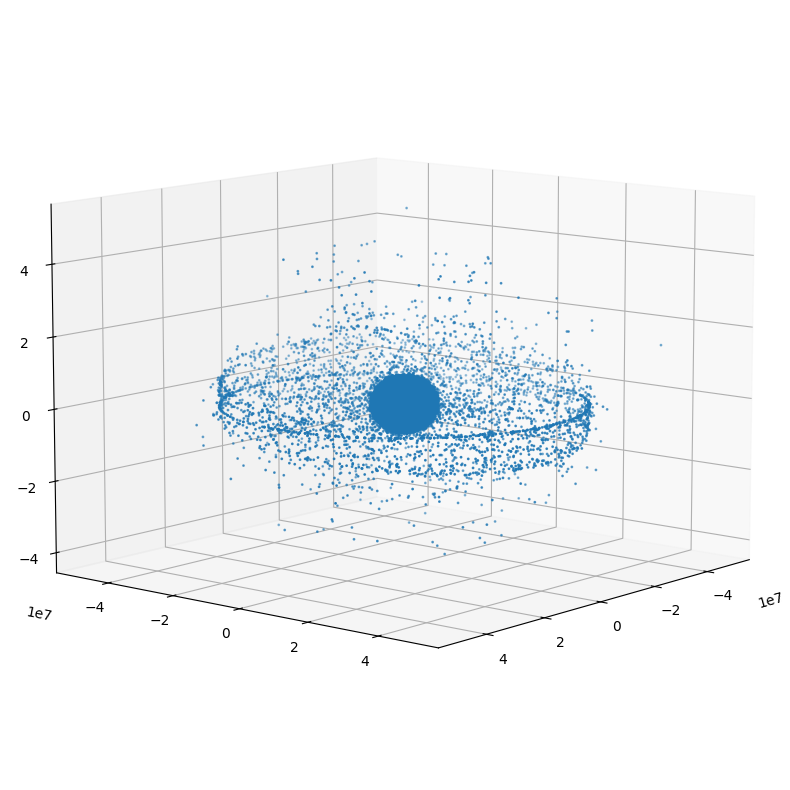

In [8]:
# Set a maximum distance and create a mask for filtering out distance > maxrad 
maxrad = 5.0e7
mask = (abs(XX) < maxrad) & (abs(YY) < maxrad) & (abs(ZZ) < maxrad) 

#initialise figure and axes. Make figure larger than the jupyter default
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')

#plot the masked XYZ values. make size of markers smaller (s = 1)
ax.scatter3D(XX[mask],YY[mask],ZZ[mask], s = 1)

# rotate the axes and update (angle in z, angle in xy plane)
ax.view_init(10,40)


More:
* Try other dates.
* Try making a movie (there are several libraries and approches for that) changing the view angle and time.

### Prepare to export the data to a csv file

We did a 3D plot of the Earth's orbital environment today. That was nice. But now we want to export the data to a file so that we can explore them with more specialised interactive visualisation software. 

For that we will export to a CSV file, with a header identifying the data exported. Lets take a look into the EarthSatellite object attributes:

Criar uma lista de atributos (vimos no notebook anterior) para um dos objetos (os outros obejtos têm os mesmo atributos, com valores diferentes).

In [9]:
# Create the "attrlist" array (we saw how to do this in previous tutorials)
# We will use the first object in the list (index "0") as a template

attrlist=dir(objlist[0])
print(attrlist)

['M', '_M', '__class__', '__copy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_ap', '_decay', '_drag', '_e', '_epoch', '_inc', '_n', '_orbit', '_raan', 'a_dec', 'a_epoch', 'a_ra', 'alt', 'ap', 'az', 'catalog_number', 'circumpolar', 'compute', 'copy', 'dec', 'decay', 'drag', 'e', 'eclipsed', 'elevation', 'elong', 'epoch', 'g_dec', 'g_ra', 'ha', 'inc', 'mag', 'n', 'name', 'neverup', 'orbit', 'parallactic_angle', 'ra', 'raan', 'radius', 'range', 'range_velocity', 'rise_az', 'rise_time', 'set_az', 'set_time', 'size', 'sublat', 'sublong', 'transit_alt', 'transit_time', 'writedb']


Lets check the attribute values.

Info. mais detalhada sobre cada atributo.

In [10]:
nobj = 0
print("** Attributes for %s ** (name, value)"%objlist[nobj].name)
for attr in attrlist:
    a = getattr(objlist[nobj], attr)
    print("%s\t %s" % (attr,a))    


** Attributes for 0 VANGUARD 1 ** (name, value)
M	 209.601806640625
_M	 209:36:06.5
__class__	 <class 'ephem.EarthSatellite'>
__copy__	 <built-in method __copy__ of ephem.EarthSatellite object at 0x7f7e45337760>
__delattr__	 <method-wrapper '__delattr__' of ephem.EarthSatellite object at 0x7f7e45337760>
__dir__	 <built-in method __dir__ of ephem.EarthSatellite object at 0x7f7e45337760>
__doc__	 A satellite in orbit around the Earth, usually built by passing the text of a TLE entry to the `ephem.readtle()` routine. You can read and write its orbital parameters through the following attributes:

_ap -- argument of perigee at epoch (degrees)
_decay -- orbit decay rate (revolutions per day-squared)
_drag -- object drag coefficient (per earth radius)
_e -- eccentricity
_epoch -- reference epoch (mjd)
_inc -- inclination (degrees)
_M -- mean anomaly (degrees from perigee at epoch)
_n -- mean motion (revolutions per day)
_orbit -- integer orbit number of epoch
_raan -- right ascension of asce

/tmp/ipykernel_467/1224488216.py:4: DeprecationWarning: the ephem.Body attributes 'rise_time', 'rise_az', 'transit_time', 'transit_alt', 'set_time', 'set_az', 'circumpolar', and 'never_up' are deprecated; please convert your program to use the ephem.Observer functions next_rising(), previous_rising(), next_transit(), and so forth

  a = getattr(objlist[nobj], attr)


#### Select attributes
Many attributes refer to methods, docstrings, etc, which we dont want in our output file.
We only want to export those with actual data:

'_ap', '_decay', '_drag', '_e', '_epoch', '_inc', '_n', '_orbit', '_raan', 'a_dec', 'a_epoch', 'a_ra', 'alt', 'az', 'catalog_number', 'circumpolar', 'dec', 'eclipsed', 'elevation', 'elong', 'g_dec', 'g_ra', 'mag', 'name', 'neverup', 'ra', 'radius', 'range', 'range_velocity', 'rise_az', 'rise_time', 'set_az', 'set_time', 'size', 'sublat', 'sublong', 'transit_alt', 'transit_time'

Note that the XYZ coordinates have been determined separately and are not included in the EarthSatellite object. We will deal with them separately.

In [11]:
# array with attributes to export
attrlist = ['_ap', '_decay', '_drag', '_e', '_epoch', '_inc', '_n', '_orbit', '_raan', 'a_dec', 
               'a_epoch', 'a_ra', 'alt', 'az', 'catalog_number', 'circumpolar', 'dec', 'eclipsed', 
               'elevation', 'elong', 'g_dec', 'g_ra', 'mag', 'name', 'neverup', 'ra', 'radius', 'range', 
               'range_velocity', 'rise_az', 'rise_time', 'set_az', 'set_time', 'size', 'sublat', 'sublong', 
               'transit_alt', 'transit_time']

Now, create the header array, which will also include the X,Y,Z coordinates that you have computed.

**Create an array called "header" with the names of the variables. It will be used for printing the header into the output file** 

Note: we may also make the header more human friendy by changing the names in some fields (e.g. _n -> mean motion). Remember that the "help" instructuion provides a description of the attributes.

In [12]:
# Create the "header" array
header = attrlist.copy()
header.append('X')
header.append('Y')
header.append('Z')
print(header)

['_ap', '_decay', '_drag', '_e', '_epoch', '_inc', '_n', '_orbit', '_raan', 'a_dec', 'a_epoch', 'a_ra', 'alt', 'az', 'catalog_number', 'circumpolar', 'dec', 'eclipsed', 'elevation', 'elong', 'g_dec', 'g_ra', 'mag', 'name', 'neverup', 'ra', 'radius', 'range', 'range_velocity', 'rise_az', 'rise_time', 'set_az', 'set_time', 'size', 'sublat', 'sublong', 'transit_alt', 'transit_time', 'X', 'Y', 'Z']


#### Writing the output to a csv file.

* Open an output file for writing (create if necessary)
* Write the header to the file

In [13]:
# Open the file for writing (create if necessary)
resultFile = open("XYZtle_07112023.csv",'w')
wr = csv.writer(resultFile, delimiter=',')

# write the header
# Note: we may also make the header more human friendy by changing the names in some fields
# (e.g. _n -> mean motion)
wr.writerow(header)


275

* Write the data to the csv file. 

There will be several exceptions that you will need to handle*

Tip: This takes quite a while. You can use a shorter TLE file for testing.

Iterra ao longo de cada objeto. Cria linha de output vazia. Preenche com os atributos. Para cada atributo na lista de atributos, usar método try e excluir exceções. Chegando ao fim, adicionar também os valores de x, y e z (com extend, faz append dos 3 juntos). Escrever a linha de saída, continuar o ciclo. No fim, fechar o ficheiro.

In [14]:
# Write the data. Don't forget to include X, Y and Z

# iterate over the objects
for i in range(0, len(objlist)):
    outline = []
    # fill the output line by iterating over the object's attributes
    for attr in attrlist:
        try:
            a = getattr(objlist[i], attr)
        except RuntimeError:
            a = (float('nan'))
        try:
            outline.append(float(a))
        except ValueError:
            outline.append(a)
        except TypeError:
            outline.append(float('nan'))

    # append the computed XYZ (example using extend instead of append)
    outline.extend((XX[i], YY[i], ZZ[i]))  
    # write the line for this object
    wr.writerow(outline)

# close the output file
resultFile.close() 


#### That's it. Now continue exploring with Topcat.